## Summary

Exploratory data analysis - plot distribution of Allstate claim loss and other features. 
Convert the categorical data (strings) to integers.
Run a random forest regression model using all features (and 50% of train data) - look for the most important features.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_context('poster')
%matplotlib inline

In [2]:
loc = '/Users/elena/Documents/Kaggle/Allstate/data/'
train = pd.read_csv(loc+'train.csv')
train.columns

test = pd.read_csv(loc+'test.csv')

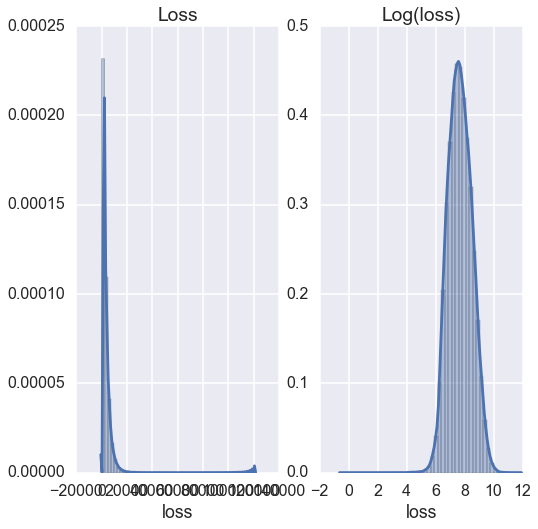

In [3]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
sns.distplot(train['loss'])
plt.title('Loss')

plt.subplot(1,2,2)
sns.distplot(np.log(train['loss']))
plt.title('Log(loss)')


In [4]:
# List of categorical columns
keepcats = [col for col in train.columns if 'cat' in col]
# List of continuous columns
keepcont = [col for col in train.columns if 'cont' in col]

print 'Categorical: ',len(keepcats)
print 'Continuous: ',len(keepcont)

Categorical:  116
Continuous:  14


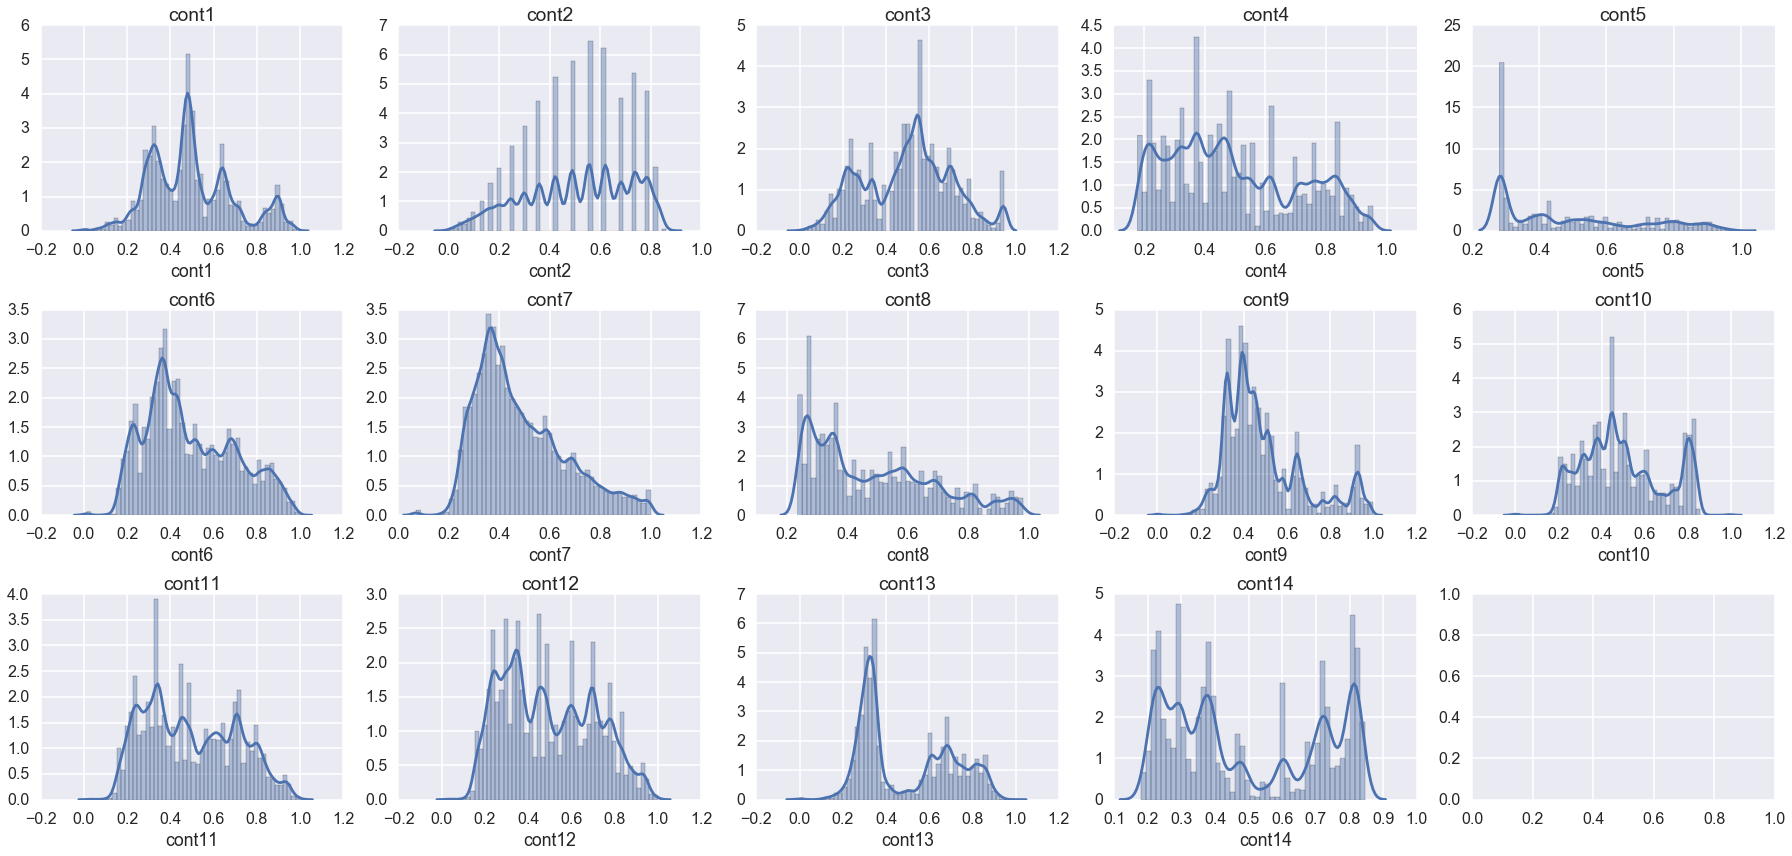

In [5]:
fig, axes = plt.subplots(3,5)
fig.set_size_inches(25, 12)
a = 1
for column in keepcont:
    plt.subplot(3,5,a)
    sns.distplot(train[column])
    plt.title(column)
    a+=1
    
plt.tight_layout()


/Users/elena/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Average MAE (1/2 training data):  849.632984078
Average MAE (other half train data):  1937.52431538


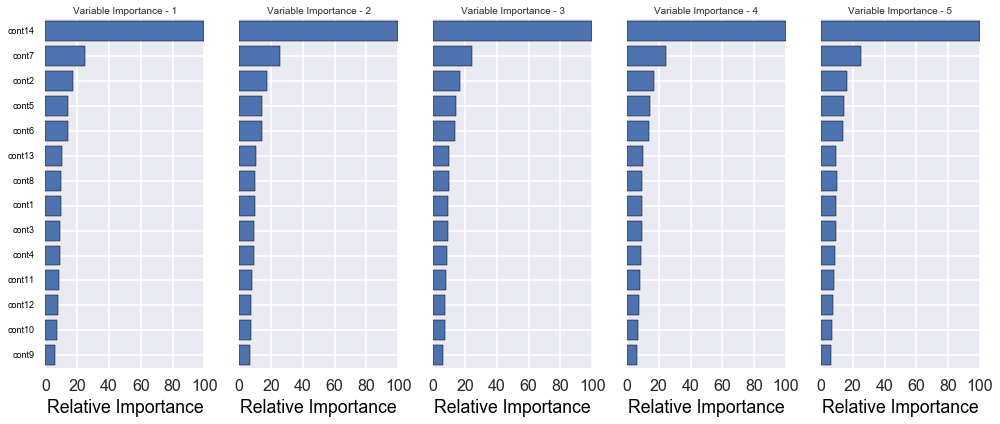

In [6]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.cross_validation import train_test_split
from sklearn.metrics import mean_squared_error,mean_absolute_error

# Define features and target for Random Forest model
# let's only use the continuous features in the dataset for now
cont_only = train[keepcont]
cont_only['log-loss']=np.log(train['loss'])

x = cont_only[keepcont]
y = cont_only['log-loss']

plt.figure(figsize=(14,6))

avg_rmse = 0
avg_rmse2 = 0
for b in range(5):
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=.5)

    # Fit an Extra Trees model to the data
    model = RandomForestRegressor()
    model.fit(X_train, y_train)
    # display the relative importance of each attribute
    feature_importance = model.feature_importances_
    
    mae = mean_absolute_error(np.exp(y_train),np.exp(model.predict(X_train)))
    mae2 = mean_absolute_error(np.exp(y_test),np.exp(model.predict(X_test)))
    
    avg_rmse+=mae
    avg_rmse2+=mae2
    ####################################################
    # Plot the feature importances
    plt.subplot(1,5,b+1)
    # make importances relative to most important feature
    feature_importance = 100.0 * (feature_importance / feature_importance.max())
    if b==0:
        sorted_idx = np.argsort(feature_importance)
        pos = np.arange(sorted_idx.shape[0]) + .5
    plt.barh(pos, feature_importance[sorted_idx], align='center')
    if b==0:
        plt.yticks(pos, np.array(keepcont)[sorted_idx],color='k',fontsize=9)
    else:
        plt.yticks(pos,[])
#         frame = plt.gca()
#         frame.axes.yaxis.set_ticklabels([])
    plt.xlabel('Relative Importance',color='k')
    plt.title('Variable Importance - '+str(b+1),fontsize=10)
    
    #plt.text(25,3.5,r'RMSE$_{train}$= '+str(round(np.sqrt(mse),3)),fontsize=14)
    #plt.text(25,2.5,r'RMSE$_{test}$= '+str(round(np.sqrt(mse2),3)),fontsize=14)

plt.tight_layout()

print 'Average MAE (1/2 training data): ',avg_rmse/5.0
print 'Average MAE (other half train data): ',avg_rmse2/5.0

### Convert Categorical data

In [7]:
def convert_strings(pdseries):
    # Function inputs a column of a pandas DataFrame,
    # determines the number of unique entries, and assigns 
    # an integer to each entry. 
    # This is to avoid issues with non-integer data.
      
    array = np.array(pdseries)
    vals = np.unique(array)
    nums = np.arange(0,len(vals),1)
      
    new_array = np.zeros(len(array),dtype='int')
    for j in range(len(vals)):
        ind = np.where(array==vals[j])[0]
        new_array[ind]=nums[j]
     
    # Returns a numpy array with an integer for each entry
    return new_array

In [8]:
for col in keepcats:
    to_numbers = convert_strings(train[col])
    train[col] = to_numbers

MAE:  536.058988579


(110, 130)

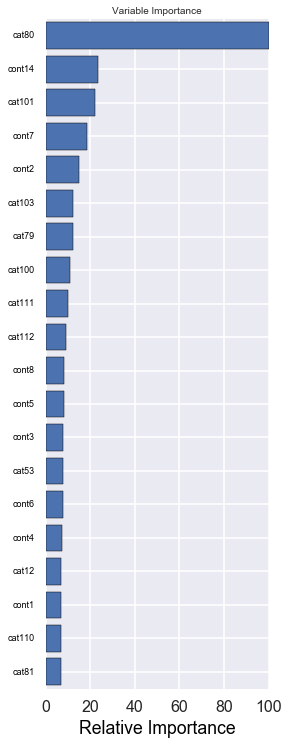

In [10]:
features = [col for col in train.columns if col not in ['id','loss','log-loss']]
x = train[features]
train['log-loss'] = np.log(train['loss'])
y = train['log-loss']

# Test on the full training dataset
model = RandomForestRegressor()
model.fit(x, y)
# display the relative importance of each attribute
feature_importance = model.feature_importances_

mae = mean_absolute_error(np.exp(y),np.exp(model.predict(x)))
#mae2 = mean_absolute_error(y_test,model.predict(X_test))

print 'MAE: ',mae

####################################################
# Plot the feature importances
plt.figure(figsize=(4,12))

# make importances relative to most important feature
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.array(features)[sorted_idx],color='k',fontsize=9)
plt.xlabel('Relative Importance',color='k')
plt.title('Variable Importance',fontsize=10)
plt.ylim([len(sorted_idx)-20,len(sorted_idx)]) # Only plot top 20 (otherwise plot is crowded)

In [11]:
submission = pd.read_csv(loc+"sample_submission.csv")
for col in keepcats:
    to_numbers = convert_strings(test[col])
    test[col] = to_numbers

test_x = test[features]
submission.iloc[:, 1] = np.exp(model.predict(test_x))
submission.head()
#submission.to_csv('random_forest1.csv', index=None)

id         loss
0   4  1818.923554
1   6  2047.696458
2   9  6651.186452
3  12  6736.995175
4  15   702.092353

(0, 10)

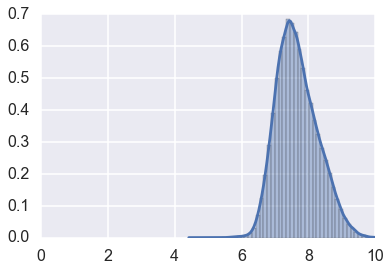

In [12]:
sns.distplot(model.predict(test_x))
plt.xlim([0,10])